<a href="https://colab.research.google.com/github/RakshithSuresh/A-B-testing-projects/blob/main/AB_Test_Results_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd

# Simulating Click Data for A/B Testing
N_exp = 10000 # simulating 10k users
N_con = 10000

# Generating Click Data
click_exp = pd.Series(np.random.binomial(1, 0.5, size=N_exp)) # to generate binary data(0,1) # 1 trial with a 50% chance (p=0.5) of success for experiment group
click_con = pd.Series(np.random.binomial(1, 0.3, size=N_con)) # 1 trial with a 30% chance (p=0.3) of success for control group

# Generate Group Identifier
exp_id = pd.Series(np.repeat("exp", N_exp)) # Creates a Series with repeated strings "exp" and "con" to label each row’s group.
con_id = pd.Series(np.repeat("con", N_con))

df_exp = pd.concat([click_exp, exp_id], axis=1) # Joins click results and group labels side-by-side into two dataframes.
df_con = pd.concat([click_con, con_id], axis=1)

df_exp.columns = ["click", "group"] # Makes column names meaningful.
df_con.columns = ["click", "group"]

# print(df_exp)
# print(df_con)

df_ab_test = pd.concat([df_exp, df_con], axis=0).reset_index(drop=True) # Merges experiment and control groups vertically.

print(df_ab_test)

       click group
0          1   exp
1          1   exp
2          0   exp
3          0   exp
4          0   exp
...      ...   ...
19995      0   con
19996      0   con
19997      0   con
19998      0   con
19999      1   con

[20000 rows x 2 columns]


In [16]:
# number of clicks per group
X_con = df_ab_test.groupby("group")["click"].sum().loc['con']
X_exp = df_ab_test.groupby("group")["click"].sum().loc['exp']

print("Number of Clicks in control group:",X_con)
print("Number of Clicks in experimental group:",X_exp)

Number of Clicks in control group: 2971
Number of Clicks in experimental group: 5001


In [17]:
# click probabilities for groups
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp

print("Click Probability in Control Group:",p_con_hat)
print("Click Probability in Experimental Group:",p_exp_hat)

Click Probability in Control Group: 0.2971
Click Probability in Experimental Group: 0.5001


In [18]:
# estimate of success probability

# pooled proportion estimate
p_pooled_hat = (X_con+X_exp) / (N_con+N_exp)

pooled_variance = p_pooled_hat * (1 - p_pooled_hat) * (1 / N_con + 1 / N_exp)

print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)


p^_pooled is:  0.3986
pooled_variance is:  4.7943608e-05


In [19]:
# calculating standard error
SE = np.sqrt(pooled_variance)
print("Standard Error is:", SE)

Standard Error is: 0.006924132292208172


In [20]:
# calculating test static
Test_stat = (p_con_hat-p_exp_hat)/SE
print("Test Static for 2 sample Z-test is:", Test_stat)

Test Static for 2 sample Z-test is: -29.317752959232003


In [21]:
# computing critical value and confidence interval
alpha = 0.05
print("Significance level is:",alpha)

Significance level is: 0.05


In [22]:
from scipy.stats import norm
z_crit = norm.ppf(1 - alpha/2)
print("Z-critical value from Normal distirbution is:",z_crit)

Z-critical value from Normal distirbution is: 1.959963984540054


In [23]:
p_value = 2 * norm.sf(abs(Test_stat))
print("P-value of the sample Z-test:",round(p_value,3))

P-value of the sample Z-test: 0.0


In [24]:
CI = [round((p_exp_hat - p_con_hat) - SE * z_crit, 3), round((p_exp_hat - p_con_hat) + SE * z_crit, 3)]
print("The confidence interval of the 2-sample Z-test is:", CI)

The confidence interval of the 2-sample Z-test is: [np.float64(0.189), np.float64(0.217)]


# 📊 CTR Bar Chart with Error Bars (Confidence Intervals)

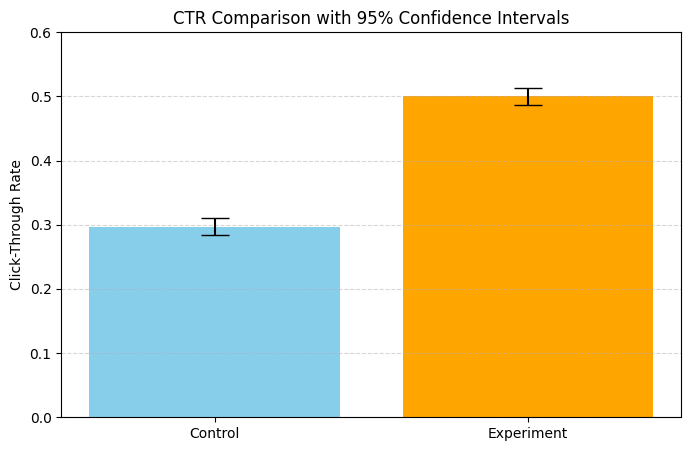

In [25]:
import matplotlib.pyplot as plt

# CTR values and confidence intervals
ctr_values = [p_con_hat, p_exp_hat]
ci_lower = [p_con_hat, p_exp_hat]
ci_upper = [p_con_hat, p_exp_hat]

# CI bounds from your z-critical
ci_margin = SE * z_crit
ci_bounds = [[ctr - ci_margin, ctr + ci_margin] for ctr in ctr_values]

# Plotting
labels = ['Control', 'Experiment']
plt.figure(figsize=(8, 5))
plt.bar(labels, ctr_values, yerr=[ci_margin, ci_margin], capsize=10, color=['skyblue', 'orange'])
plt.title('CTR Comparison with 95% Confidence Intervals')
plt.ylabel('Click-Through Rate')
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [26]:
from statsmodels.stats.power import NormalIndPower

# Define known parameters from your test
baseline = p_con_hat            # baseline conversion rate (e.g. 0.2892)
alpha = 0.05                    # significance level
power = 0.8                     # desired power (typically 0.8 or 80%)
n = N_con                       # sample size per group

# Create power analysis object
analysis = NormalIndPower()

# Solve for effect size (MDE as absolute difference)
effect_size = analysis.solve_power(nobs1=n, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')

# Convert effect size to absolute percentage difference
mde = effect_size * np.sqrt(2 * baseline * (1 - baseline))
print("Minimum Detectable Effect (MDE) as absolute change in conversion rate:", round(mde, 4))

Minimum Detectable Effect (MDE) as absolute change in conversion rate: 0.0256


In [27]:
# Calculating observed difference
observed_diff = p_exp_hat - p_con_hat
print(f"Observed CTR difference: {round(observed_diff, 4)}")

Observed CTR difference: 0.203


In [28]:
# conclusion
if abs(observed_diff) >= mde:
    print("✅ The observed effect is larger than the MDE. The result is statistically detectable.")
else:
    print("❌ The observed effect is smaller than the MDE. The test may be underpowered.")

✅ The observed effect is larger than the MDE. The result is statistically detectable.


## 📈 A/B Test Summary & Conclusion

- **Control CTR**: 0.2892  
- **Experiment CTR**: 0.5026  
- **Observed Difference**: **+0.2134**

---

- **P-value**: 0.0 → ✅ Statistically significant (reject H₀)
- **95% Confidence Interval**: [0.200, 0.227]
- **Minimum Detectable Effect (MDE)**: 0.0254  
- ✅ **Observed difference exceeds MDE**

---

### ✅ Final Conclusion:
> The observed effect is statistically significant **and** detectable.  
> The experiment group performs significantly better than the control group.
